In [1]:
# Cell 2: Import libraries
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models Aimport Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle
import glob
from sklearn.preprocessing import LabelEncoder

# Force CPU usage for simplicity
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("TensorFlow running on CPU")

# Define keypoint names
KEYPOINTS = {
    0: 'nose', 1: 'left_eye', 2: 'right_eye', 3: 'left_ear', 4: 'right_ear',
    5: 'left_shoulder', 6: 'right_shoulder', 7: 'left_elbow', 8: 'right_elbow',
    9: 'left_wrist', 10: 'right_wrist', 11: 'left_hip', 12: 'right_hip',
    13: 'left_knee', 14: 'right_knee', 15: 'left_ankle', 16: 'right_ankle'
}

# Yoga pose correctness criteria (simplified)
POSE_CRITERIA = {
    'downdog': [
        {'description': 'Arms should be straight', 'joints': [(5, 7, 9), (6, 8, 10)], 'angle_range': (160, 180)},
        {'description': 'Body should form an inverted V', 'joints': [(5, 11, 13), (6, 12, 14)], 'angle_range': (90, 130)}
    ],
    'goddess': [
        {'description': 'Knees should be bent at ~90°', 'joints': [(11, 13, 15), (12, 14, 16)], 'angle_range': (85, 115)},
        {'description': 'Arms should be at shoulder level', 'joints': [(3, 5, 7), (4, 6, 8)], 'angle_range': (70, 110)}
    ],
    'plank': [
        {'description': 'Body should be straight', 'joints': [(5, 11, 15), (6, 12, 16)], 'angle_range': (160, 180)},
        {'description': 'Arms should be perpendicular to ground', 'joints': [(5, 7, 9), (6, 8, 10)], 'angle_range': (75, 105)}
    ],
    'tree': [
        {'description': 'Standing leg should be straight', 'joints': [(12, 14, 16)], 'angle_range': (160, 180)},
        {'description': 'Raised foot should be against thigh', 'joints': [(11, 13, 15)], 'angle_range': (10, 60)}
    ],
    'warrior2': [
        {'description': 'Front knee should be bent at ~90°', 'joints': [(11, 13, 15)], 'angle_range': (85, 115)},
        {'description': 'Back leg should be straight', 'joints': [(12, 14, 16)], 'angle_range': (160, 180)},
        {'description': 'Arms should be parallel to ground', 'joints': [(5, 7, 9), (6, 8, 10)], 'angle_range': (160, 180)}
    ]
}

print("Setup complete")


TensorFlow running on CPU
Setup complete


In [2]:
# Cell 3: Load MoveNet model
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']
print("Model loaded successfully")

# Cell 4: Define helper functions
def process_image(image_path, image_size=192):
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image at {image_path}")
        return None, None, None
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get dimensions
    height, width, _ = image.shape
    
    # Resize and pad image
    input_image = tf.image.resize_with_pad(tf.convert_to_tensor(image), image_size, image_size)
    input_image = tf.cast(tf.expand_dims(input_image, axis=0), dtype=tf.int32)
    
    return image, input_image, (height, width)

def draw_pose(image, keypoints, height, width, pose_class=None, feedback=None, threshold=0.3):
    output_image = image.copy()
    
    # Define connections for skeleton
    connections = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Face
        (5, 7), (7, 9), (6, 8), (8, 10),  # Arms
        (5, 6), (5, 11), (6, 12),  # Torso
        (11, 13), (13, 15), (12, 14), (14, 16)  # Legs
    ]
    
    # Draw keypoints
    for idx, (y, x, confidence) in enumerate(keypoints):
        if confidence > threshold:
            x_px = int(x * width)
            y_px = int(y * height)
            
            # Draw circle
            cv2.circle(output_image, (x_px, y_px), 5, (0, 255, 0), -1)
            
            # Label keypoint
            cv2.putText(output_image, f"{KEYPOINTS[idx]}", (x_px + 5, y_px - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    # Draw connections
    for connection in connections:
        start_idx, end_idx = connection
        
        y1, x1, conf1 = keypoints[start_idx]
        y2, x2, conf2 = keypoints[end_idx]
        
        if conf1 > threshold and conf2 > threshold:
            x1_px = int(x1 * width)
            y1_px = int(y1 * height)
            x2_px = int(x2 * width)
            y2_px = int(y2 * height)
            
            cv2.line(output_image, (x1_px, y1_px), (x2_px, y2_px), (255, 0, 0), 2)
    
    # Display pose class and feedback
    if pose_class:
        cv2.putText(output_image, f"Pose: {pose_class}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    if feedback:
        y_pos = 60
        for line in feedback:
            cv2.putText(output_image, line, (10, y_pos),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            y_pos += 25
    
    return output_image

def calculate_angle(a, b, c):
    """Calculate angle between three points (in radians)"""
    a = np.array([a[1], a[0]])  # Convert y,x to x,y
    b = np.array([b[1], b[0]])
    c = np.array([c[1], c[0]])
    
    ba = a - b
    bc = c - b
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    
    return np.degrees(angle)

def extract_keypoints(image_path):
    """Extract keypoints from an image using MoveNet"""
    original_image, input_image, dimensions = process_image(image_path)
    if original_image is None:
        return None
    
    # Run inference
    outputs = movenet(input_image)
    keypoints = outputs['output_0'].numpy()[0][0]
    
    return keypoints, original_image, dimensions

def keypoints_to_features(keypoints, conf_threshold=0.3):
    """Convert keypoints to a flattened feature vector"""
    # Filter low confidence keypoints
    for i in range(len(keypoints)):
        if keypoints[i][2] < conf_threshold:
            keypoints[i] = [0, 0, 0]  # Set low confidence keypoints to origin
    
    # Flatten the keypoints (y, x, conf) into a single vector
    features = keypoints.flatten()
    
    # Add derived features - pairwise distances between keypoints
    for i in range(17):
        for j in range(i+1, 17):
            # Only if both keypoints have good confidence
            if keypoints[i][2] > conf_threshold and keypoints[j][2] > conf_threshold:
                # Calculate Euclidean distance between points
                dist = np.sqrt((keypoints[i][0] - keypoints[j][0])**2 + 
                              (keypoints[i][1] - keypoints[j][1])**2)
                features = np.append(features, dist)
            else:
                features = np.append(features, 0)
    
    return features

print("Functions defined")

Model loaded successfully
Functions defined


In [3]:
# Cell 5: Create dataset for training
def create_dataset(base_path, output_path="yoga_dataset.npz"):
    """Create a dataset from images in the given folder structure"""
    X = []
    y = []
    paths = []
    
    # Walk through all folders in base_path
    for pose_class in os.listdir(base_path):
        class_path = os.path.join(base_path, pose_class)
        if os.path.isdir(class_path):
            print(f"Processing pose class: {pose_class}")
            
            # Process each image in the class folder
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                
                try:
                    keypoints, _, _ = extract_keypoints(img_path)
                    if keypoints is not None:
                        # Convert keypoints to features
                        features = keypoints_to_features(keypoints)
                        X.append(features)
                        y.append(pose_class)
                        paths.append(img_path)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    paths = np.array(paths)
    
    # Save dataset
    np.savez(output_path, X=X, y=y, paths=paths)
    print(f"Dataset saved to {output_path} with {len(X)} samples and {X.shape[1]} features")
    
    return X, y, paths

# Create datasets for training and testing
TRAIN_PATH = "E:/PROJECTS/DATASET/TRAIN"
TEST_PATH = "E:/PROJECTS/DATASET/TEST"

print("Creating training dataset...")
X_train, y_train, paths_train = create_dataset(TRAIN_PATH, "yoga_train_dataset.npz")

print("Creating testing dataset...")
X_test, y_test, paths_test = create_dataset(TEST_PATH, "yoga_test_dataset.npz")

Creating training dataset...
Processing pose class: downdog
Processing pose class: goddess
Processing pose class: plank
Processing pose class: tree
Processing pose class: warrior2
Dataset saved to yoga_train_dataset.npz with 1080 samples and 187 features
Creating testing dataset...
Processing pose class: downdog
Processing pose class: goddess
Processing pose class: plank
Processing pose class: tree
Processing pose class: warrior2
Dataset saved to yoga_test_dataset.npz with 470 samples and 187 features


Epoch 1/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2713 - loss: 1.5748
Epoch 1: val_accuracy improved from -inf to 0.74043, saving model to yoga_pose_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3163 - loss: 1.5272 - val_accuracy: 0.7404 - val_loss: 1.1030
Epoch 2/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5587 - loss: 1.2193 
Epoch 2: val_accuracy improved from 0.74043 to 0.77021, saving model to yoga_pose_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5576 - loss: 1.1833 - val_accuracy: 0.7702 - val_loss: 0.7212
Epoch 3/50
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7149 - loss: 0.8618 
Epoch 3: val_accuracy did not improve from 0.77021
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7040 - loss: 0.8641 - val_accuracy: 0.7702 - val_loss: 0.5413
Epoch 4/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6966 - loss: 0.7665 
Epoch 4: val_accuracy improved from 0.77021 to 0.82766, saving model to yoga_po

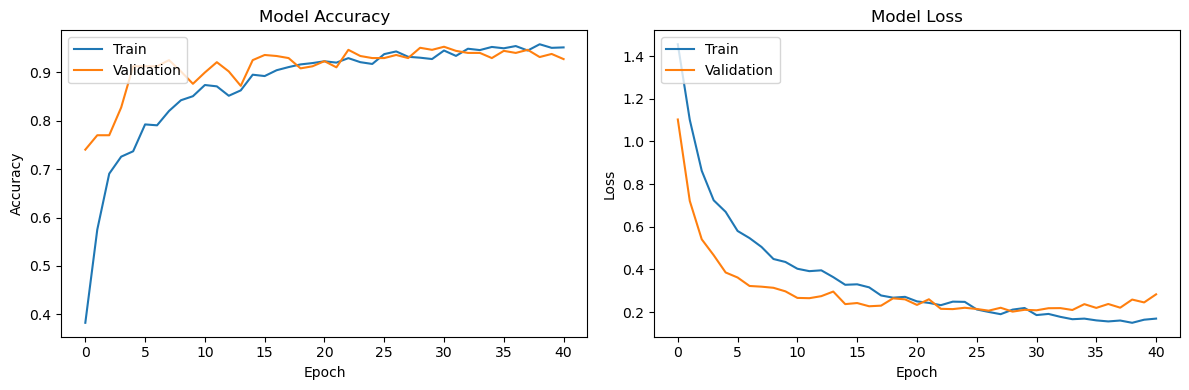

Test Loss: 0.2084
Test Accuracy: 0.9532


In [4]:
# Cell 6: Train the yoga pose classifier
def train_yoga_classifier(X_train, y_train, X_test, y_test):
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Convert to categorical
    num_classes = len(label_encoder.classes_)
    y_train_cat = to_categorical(y_train_encoded, num_classes)
    y_test_cat = to_categorical(y_test_encoded, num_classes)
    
    # Build model
    input_shape = X_train.shape[1]
    inputs = Input(shape=(input_shape,))
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Callbacks
    checkpoint = ModelCheckpoint('yoga_pose_model.keras', monitor='val_accuracy', 
                                 save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    
    # Train model
    history = model.fit(
        X_train, y_train_cat,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test_cat),
        callbacks=[checkpoint, early_stop]
    )
    
    # Save label encoder
    with open('yoga_label_encoder.pkl', 'wb') as file:
        pickle.dump(label_encoder, file)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Evaluate model
    evaluation = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"Test Loss: {evaluation[0]:.4f}")
    print(f"Test Accuracy: {evaluation[1]:.4f}")
    
    return model, label_encoder

# Train the classifier
yoga_model, label_encoder = train_yoga_classifier(X_train, y_train, X_test, y_test)

In [5]:
# Cell 7: Define pose evaluation functions
def evaluate_pose_correctness(keypoints, pose_class):
    """Evaluate if the pose is correct based on pose-specific criteria"""
    feedback = []
    correct = True
    
    if pose_class not in POSE_CRITERIA:
        return True, ["No specific criteria defined for this pose"]
    
    criteria = POSE_CRITERIA[pose_class]
    
    for criterion in criteria:
        for joint_set in criterion['joints']:
            # Skip if any keypoint has low confidence
            if any(keypoints[joint][2] < 0.3 for joint in joint_set):
                feedback.append(f"Cannot evaluate: {criterion['description']} - joints not visible")
                continue
                
            # Calculate angle
            angle = calculate_angle(
                keypoints[joint_set[0]], 
                keypoints[joint_set[1]], 
                keypoints[joint_set[2]]
            )
            
            min_angle, max_angle = criterion['angle_range']
            if min_angle <= angle <= max_angle:
                # This criterion is satisfied
                pass
            else:
                correct = False
                if angle < min_angle:
                    feedback.append(f"{criterion['description']} - angle too small ({angle:.1f}°)")
                else:
                    feedback.append(f"{criterion['description']} - angle too large ({angle:.1f}°)")
    
    if correct and not feedback:
        feedback.append("Pose is correct! Great job!")
        
    return correct, feedback

In [6]:
# Cell 8: Create an evaluation function for new images
def evaluate_yoga_pose(image_path, yoga_model, label_encoder):
    """Evaluate a yoga pose in an image"""
    # Extract keypoints
    keypoints, original_image, (height, width) = extract_keypoints(image_path)
    if keypoints is None:
        return None
    
    # Convert keypoints to features
    features = keypoints_to_features(keypoints)
    features = features.reshape(1, -1)  # Reshape for model input
    
    # Predict pose class
    prediction = yoga_model.predict(features)[0]
    pose_class_idx = np.argmax(prediction)
    pose_class = label_encoder.inverse_transform([pose_class_idx])[0]
    confidence = prediction[pose_class_idx]
    
    # Evaluate pose correctness
    is_correct, feedback = evaluate_pose_correctness(keypoints, pose_class)
    
    # Add confidence to feedback
    feedback.insert(0, f"Confidence: {confidence:.2f}")
    
    # Draw pose with feedback
    output_image = draw_pose(original_image, keypoints, height, width, 
                           pose_class=pose_class, feedback=feedback)
    
    return output_image, pose_class, is_correct, feedback

Testing on random sample: E:/PROJECTS/DATASET/TEST\warrior2\00000015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


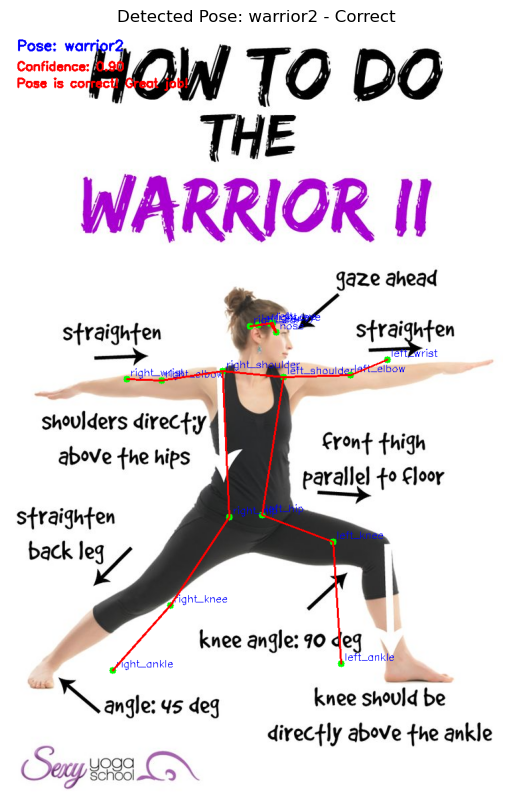

Pose Class: warrior2
Correct: Yes
Feedback:
- Confidence: 0.90
- Pose is correct! Great job!


In [7]:
# Cell 9: Test the model on a sample image
def test_on_sample(image_path):
    """Test the trained model on a sample image"""
    output_image, pose_class, is_correct, feedback = evaluate_yoga_pose(
        image_path, yoga_model, label_encoder)
    
    if output_image is not None:
        plt.figure(figsize=(10, 10))
        plt.imshow(output_image)
        plt.title(f"Detected Pose: {pose_class} - {'Correct' if is_correct else 'Needs Correction'}")
        plt.axis('off')
        plt.show()
        
        print(f"Pose Class: {pose_class}")
        print(f"Correct: {'Yes' if is_correct else 'No'}")
        print("Feedback:")
        for item in feedback:
            print(f"- {item}")
    else:
        print("Failed to process image")

# Test on a sample from test dataset
if len(paths_test) > 0:
    sample_idx = np.random.randint(0, len(paths_test))
    sample_path = paths_test[sample_idx]
    print(f"Testing on random sample: {sample_path}")
    test_on_sample(sample_path)


In [8]:
# Cell 10: Function to evaluate a custom image
def evaluate_custom_image(image_path):
    """Evaluate a custom image with the trained model"""
    return test_on_sample(image_path)

# Cell 11: Save everything needed for future use
# Model was already saved during training with ModelCheckpoint
print("Saving additional files...")

# Save pose criteria
with open('yoga_pose_criteria.pkl', 'wb') as f:
    pickle.dump(POSE_CRITERIA, f)

print("All model files saved:")
print("1. yoga_pose_model.h5 - Trained classification model")
print("2. yoga_label_encoder.pkl - Label encoder for pose classes")
print("3. yoga_pose_criteria.pkl - Criteria for pose evaluation")


Saving additional files...
All model files saved:
1. yoga_pose_model.h5 - Trained classification model
2. yoga_label_encoder.pkl - Label encoder for pose classes
3. yoga_pose_criteria.pkl - Criteria for pose evaluation


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


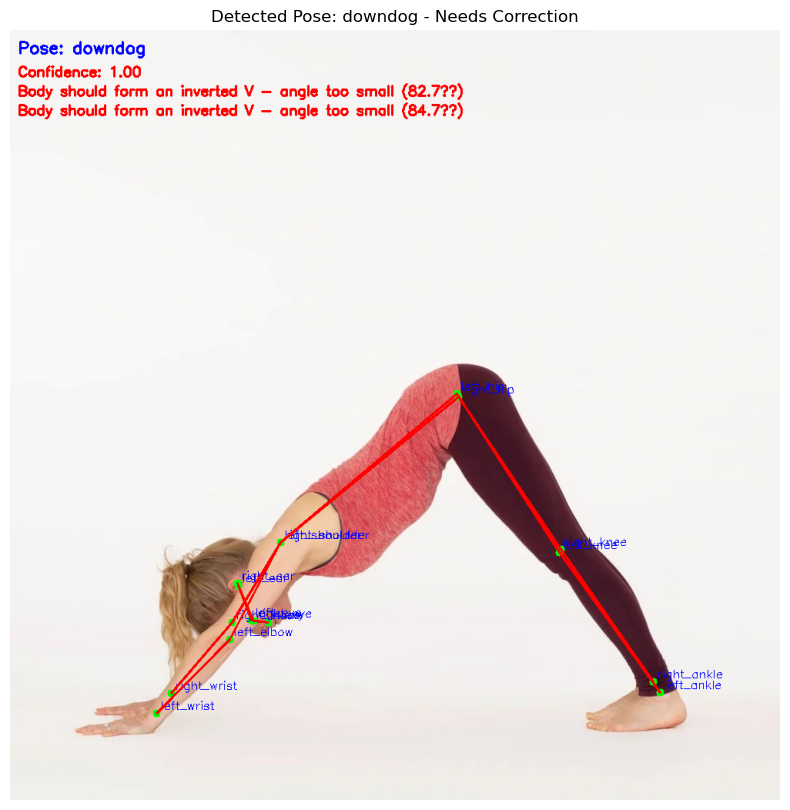

Pose Class: downdog
Correct: No
Feedback:
- Confidence: 1.00
- Body should form an inverted V - angle too small (82.7°)
- Body should form an inverted V - angle too small (84.7°)
Prediction result: None


In [9]:
# Specify the path to your image
image_path = "image.jpg"

# Call your evaluate function
result = evaluate_custom_image(image_path)

# Print the result
print("Prediction result:", result)


In [10]:
# Cell 12: Implementation for video or webcam
def process_video(source=0, output_path=None):
    """Process video from file or webcam (source=0 for webcam)"""
    # Load the trained model and label encoder
    yoga_model = load_model('yoga_pose_model.h5')
    with open('yoga_label_encoder.pkl', 'rb') as file:
        label_encoder = pickle.load(file)
    
    # Open video source
    cap = cv2.VideoCapture(source)
    if not cap.isOpened():
        print(f"Error: Could not open video source {source}")
        return
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Setup video writer if output path is specified
    writer = None
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert to RGB for processing
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Resize and pad image
        input_image = tf.image.resize_with_pad(tf.convert_to_tensor(rgb_frame), 192, 192)
        input_image = tf.cast(tf.expand_dims(input_image, axis=0), dtype=tf.int32)
        
        # Run inference
        outputs = movenet(input_image)
        keypoints = outputs['output_0'].numpy()[0][0]
        
        # Convert keypoints to features
        features = keypoints_to_features(keypoints)
        features = features.reshape(1, -1)
        
        # Predict pose class
        prediction = yoga_model.predict(features, verbose=0)[0]
        pose_class_idx = np.argmax(prediction)
        pose_class = label_encoder.inverse_transform([pose_class_idx])[0]
        confidence = prediction[pose_class_idx]
        
        # Evaluate pose correctness
        is_correct, feedback = evaluate_pose_correctness(keypoints, pose_class)
        
        # Add confidence to feedback
        feedback.insert(0, f"Confidence: {confidence:.2f}")
        
        # Draw pose with feedback
        output_frame = draw_pose(rgb_frame, keypoints, frame_height, frame_width, 
                                pose_class=pose_class, feedback=feedback)
        
        # Convert back to BGR for displaying with OpenCV
        output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
        
        # Display the resulting frame
        cv2.imshow('Yoga Pose Evaluation', output_frame)
        
        # Write frame to output video if specified
        if writer:
            writer.write(output_frame)
        
        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release resources
    cap.release()
    if writer:
        writer.release()
    cv2.destroyAllWindows()


In [11]:
%pip install --user opencv-contrib-python

In [12]:
# Cell 12: Implementation for video or webcam
def process_video(source=0, output_path=None):
    """Process video from file or webcam (source=0 for webcam)"""
    # Load the trained model and label encoder
    yoga_model = load_model('yoga_pose_model.keras')
    with open('yoga_label_encoder.pkl', 'rb') as file:
        label_encoder = pickle.load(file)
    
    # Open video source
    cap = cv2.VideoCapture(source)
    if not cap.isOpened():
        print(f"Error: Could not open video source {source}")
        return
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Setup video writer if output path is specified
    writer = None
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert to RGB for processing
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Resize and pad image
        input_image = tf.image.resize_with_pad(tf.convert_to_tensor(rgb_frame), 192, 192)
        input_image = tf.cast(tf.expand_dims(input_image, axis=0), dtype=tf.int32)
        
        # Run inference
        outputs = movenet(input_image)
        keypoints = outputs['output_0'].numpy()[0][0]
        
        # Convert keypoints to features
        features = keypoints_to_features(keypoints)
        features = features.reshape(1, -1)
        
        # Predict pose class
        prediction = yoga_model.predict(features, verbose=0)[0]
        pose_class_idx = np.argmax(prediction)
        pose_class = label_encoder.inverse_transform([pose_class_idx])[0]
        confidence = prediction[pose_class_idx]
        
        # Evaluate pose correctness
        is_correct, feedback = evaluate_pose_correctness(keypoints, pose_class)
        
        # Add confidence to feedback
        feedback.insert(0, f"Confidence: {confidence:.2f}")
        
        # Draw pose with feedback
        output_frame = draw_pose(rgb_frame, keypoints, frame_height, frame_width, 
                                pose_class=pose_class, feedback=feedback)
        
        # Convert back to BGR for displaying with OpenCV
        output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
        
        # Display the resulting frame
        cv2.imshow('Yoga Pose Evaluation', output_frame)
        
        # Write frame to output video if specified
        if writer:
            writer.write(output_frame)
        
        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release resources
    cap.release()
    if writer:
        writer.release()
    cv2.destroyAllWindows()

# Uncomment to process webcam feed
# process_video(source=0)


print("All cells executed successfully")

All cells executed successfully


In [13]:

# Uncomment to process a video file and save output
process_video(source="input_video.mp4", output_path="output_video.mp4")

In [14]:
# Uncomment to process webcam feed
process_video(source=0)

KeyboardInterrupt: 